In [290]:
import numpy as np
import dowhy
from dowhy import CausalModel
import networkx as nx
from castle.algorithms import PC

import statsmodels.formula.api as smf

import pandas as pd

from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor


import matplotlib.pyplot as plt
%matplotlib inline

In [294]:
def get_estimates(df):
    model = CausalModel(
        data = df,
        treatment="T",
        outcome="Y",
        graph=test_gml
    )

    estimand = model.identify_effect()
    print(estimand)

    estimate_dml_linear = model.estimate_effect(
        identified_estimand=estimand,
        method_name="backdoor.econml.dml.LinearDML",
        treatment_value=1,
        method_params={
            "init_params":{
                "model_y": GradientBoostingRegressor(),
                "model_t": GradientBoostingRegressor(),
            },
        "fit_params": {}
        }
    )

    estimate_dml_lasso = model.estimate_effect(
        identified_estimand=estimand,
        method_name="backdoor.econml.dml.DML",
        treatment_value=1,
        method_params={
            "init_params":{
                "model_y": GradientBoostingRegressor(),
                "model_t": GradientBoostingRegressor(),
                "model_final": LassoCV(fit_intercept=False)
            },
        "fit_params": {}
        }
    )

    estimate_causal_forests = model.estimate_effect(
        identified_estimand=estimand,
        method_name="backdoor.econml.dml.CausalForestDML",
        treatment_value=1,
        method_params={
            "init_params":{
                "model_y": GradientBoostingRegressor(),
                "model_t": GradientBoostingRegressor()
            },
        "fit_params": {}
        }
    )
    print("Linear DML", estimate_dml_linear, "\n"*5)
    print("DML Lasso", estimate_dml_lasso, "\n"*5)
    print("Causal Forest", estimate_causal_forests, "\n"*5)

    return estimate_dml_linear, estimate_dml_lasso, estimate_causal_forests

# Set a graph

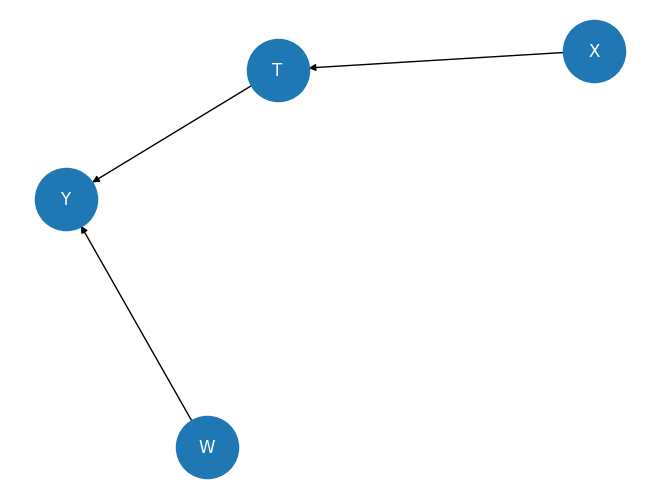

In [172]:
test_gml = """graph[
    directed 1

    node [
        id 0
        label "T"
    ]

    node [
        id 1
        label "Y"
    ]

    node [
        id 2
        label "W"

    ]

    node [
        id 3
        label "X"
    ]

    edge [
        source 0
        target 1
    ]

    edge [
        source 2
        target 1
    ]

    edge [
        source 3
        target 0
    ]
]
"""

graph = nx.parse_gml(test_gml)

nx.draw(graph,
        with_labels=True,
        font_color="white",
        node_size=2000)

# 1. Linear and normal

In [299]:
N_SAMPLES = 10_000

noise_y = np.random.randn(N_SAMPLES) * 3

W = np.random.randn(N_SAMPLES)
X = np.random.randn(N_SAMPLES)
T = 2 * X + np.random.randn(N_SAMPLES) 
Y = 2 * T + 3 * W + noise_y

y_0 = 3 * W + noise_y
y_1 = Y

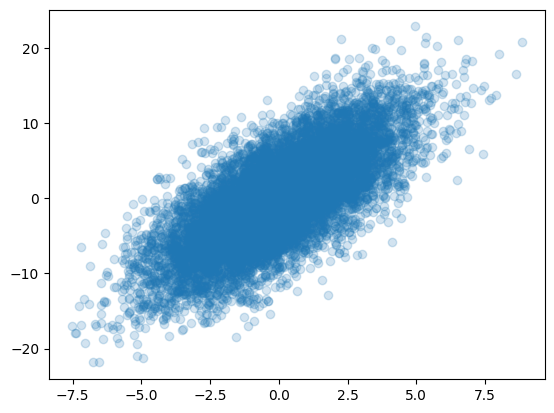

In [300]:
plt.scatter(x=T, y=Y, alpha=.2)

In [301]:
df = pd.DataFrame(dict(
    X=X,
    Y=Y,
    T=T,
    W=W
))

model = smf.ols("Y ~  T + W", df)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                 1.585e+04
Date:                Mon, 07 Aug 2023   Prob (F-statistic):               0.00
Time:                        10:01:50   Log-Likelihood:                -25339.
No. Observations:               10000   AIC:                         5.068e+04
Df Residuals:                    9997   BIC:                         5.071e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0042      0.031     -0.138      0.891      -0.064       0.056
T              2.0235      0.014    148.674      0.000       1.997       2.050
W              3.0127      0.031     98.408      0.000       2.953       3.073
==============================================================================
Omnibus:                        1.304   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.521   Jarque-Bera (JB):                1.312
Skew:                           0.006   Prob(JB):                        0.519
Kurtosis:                       2.945   Cond. No.                         2.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [302]:
linear, lasso, cf = get_estimates(df)



2023-08-07 10:01:54,487 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_model.py[line:463] - INFO: Model to find the causal effect of treatment ['T'] on outcome ['Y']
2023-08-07 10:01:54,488 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:727] - INFO: Causal effect can be identified.
2023-08-07 10:01:54,489 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:244] - INFO: Instrumental variables for treatment and outcome:['X']
2023-08-07 10:01:54,490 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:259] - INFO: Frontdoor variables for treatment and outcome:[]
2023-08-07 10:01:54,491 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/do

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[T]      
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,,U) = P(Y|T,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([T])⎟  ⎥
 ⎣d[X]    ⎝d[X]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{X})
Estimand assumption 2, Exclusion: If we remove {X}→{T}, then ¬({X}→Y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
2023-08-07 10:01:55,216 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_estimators/econml.py[line:106] - INFO: INFO: Using EconML Estimator
2023-08-07 10:01:55,220 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_estimators/econml.py[line:178] - INFO: b: Y~T | W
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
2023-08-07 10:01:55,916 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_estimators/econml.py[line:106] - INFO: INFO: Using EconML Estimator
2023-08-07 10:01:55,931 - /Users/d

Linear DML *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[T]      
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,,U) = P(Y|T,)

## Realized estimand
b: Y~T | W
Target units: ate

## Estimate
Mean value: 2.019088994556476
Effect estimates: [[2.024]
 [2.019]
 [2.022]
 ...
 [2.02 ]
 [2.021]
 [2.018]]
 





DML Lasso *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[T]      
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,,U) = P(Y|T,)

## Realized estimand
b: Y~T | W
Target units: ate

## Estimate
Mean value: 2.0154312510621524
Effect estimates: [[2.041]
 [2.015]
 [2.03 ]
 ...
 [2.018]
 [2.024]
 [2.009]]
 





Causal Forest *** Causal Estimate ***

## Identified estimand
Estimand typ

In [395]:
m = CausalModel(df, treatment="T", outcome="Y", graph=test_gml)
estimando = m.identify_effect()
estimador = m.estimate_effect(
    identified_estimand=estimando,
    method_name="backdoor.econml.dml.SparseLinearDML",
    method_params={"init_params": {
        "model_y": GradientBoostingRegressor(),
        "model_t": GradientBoostingRegressor()
    }}

)

2023-08-07 11:40:46,038 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_model.py[line:463] - INFO: Model to find the causal effect of treatment ['T'] on outcome ['Y']
2023-08-07 11:40:46,039 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:727] - INFO: Causal effect can be identified.
2023-08-07 11:40:46,040 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:244] - INFO: Instrumental variables for treatment and outcome:['X']
2023-08-07 11:40:46,041 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:259] - INFO: Frontdoor variables for treatment and outcome:[]
2023-08-07 11:40:46,042 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/do

In [397]:
print(estimador)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[T]      
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,,U) = P(Y|T,)

## Realized estimand
b: Y~T | W
Target units: ate

## Estimate
Mean value: 0.9009284900581078
Effect estimates: [[0.878]
 [0.902]
 [0.892]
 ...
 [0.905]
 [0.884]
 [0.904]]



(array([ 293.,  858., 1952., 2692., 2836., 1010.,  208.,   95.,   24.,
          32.]),
 array([1.481, 1.63 , 1.778, 1.927, 2.076, 2.224, 2.373, 2.522, 2.671,
        2.819, 2.968]),
 <BarContainer object of 10 artists>)

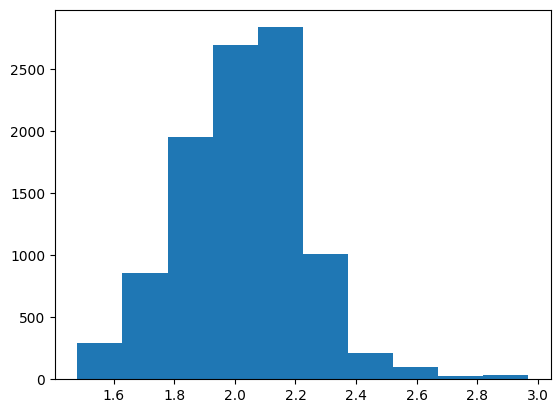

In [314]:
plt.hist(cf.cate_estimates.T[0])

# Linear and not normal

In [339]:
N_SAMPLES = 10_000

noise_y = np.random.randn(N_SAMPLES) * 3

W = np.random.gamma(size=N_SAMPLES, shape=1)
X = np.random.gamma(size=N_SAMPLES, shape=1)
T = 2 * X + np.random.randn(N_SAMPLES) * .5
Y = 2 * T + 3 * W + noise_y

y_0 = 3 * W + noise_y
y_1 = Y

(array([6.423e+03, 2.314e+03, 8.020e+02, 2.930e+02, 1.130e+02, 3.400e+01,
        1.400e+01, 3.000e+00, 2.000e+00, 2.000e+00]),
 array([1.800e-04, 1.044e+00, 2.087e+00, 3.131e+00, 4.174e+00, 5.218e+00,
        6.261e+00, 7.305e+00, 8.349e+00, 9.392e+00, 1.044e+01]),
 <BarContainer object of 10 artists>)

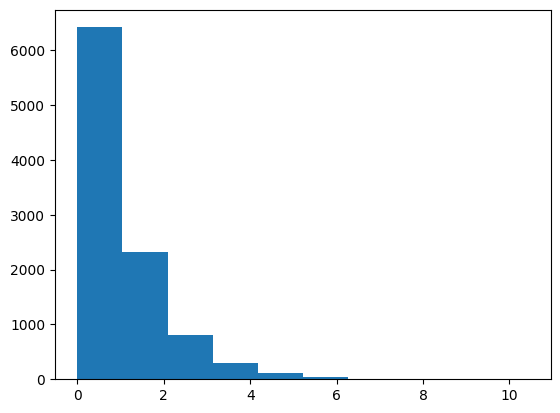

In [342]:
plt.hist(W)

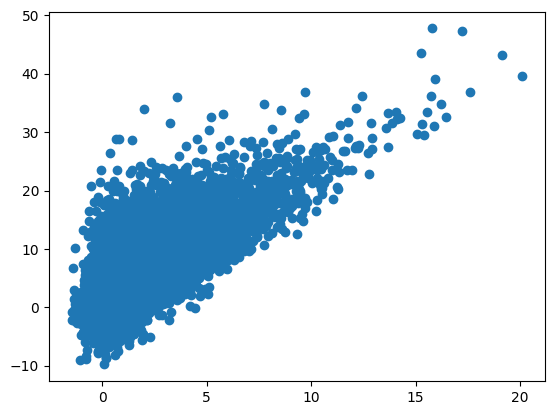

In [341]:
plt.scatter(x=T, y=Y)

In [343]:
df = pd.DataFrame(dict(
    X=X,
    Y=Y,
    T=T,
    W=W
))

model = smf.ols("Y ~  T + W", df)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                 1.528e+04
Date:                Mon, 07 Aug 2023   Prob (F-statistic):               0.00
Time:                        10:09:37   Log-Likelihood:                -25117.
No. Observations:               10000   AIC:                         5.024e+04
Df Residuals:                    9997   BIC:                         5.026e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0594      0.051     -1.167      0.243      -0.159       0.040
T              1.9979      0.014    141.472      0.000       1.970       2.026
W              3.0066      0.029    102.237      0.000       2.949       3.064
==============================================================================
Omnibus:                        0.501   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.778   Jarque-Bera (JB):                0.481
Skew:                          -0.016   Prob(JB):                        0.786
Kurtosis:                       3.013   Cond. No.                         5.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [344]:
linear, lasso, cf = get_estimates(df)

2023-08-07 10:10:03,361 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_model.py[line:463] - INFO: Model to find the causal effect of treatment ['T'] on outcome ['Y']
2023-08-07 10:10:03,362 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:727] - INFO: Causal effect can be identified.
2023-08-07 10:10:03,363 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:244] - INFO: Instrumental variables for treatment and outcome:['X']
2023-08-07 10:10:03,364 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:259] - INFO: Frontdoor variables for treatment and outcome:[]
2023-08-07 10:10:03,365 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/do

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[T]      
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,,U) = P(Y|T,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([T])⎟  ⎥
 ⎣d[X]    ⎝d[X]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{X})
Estimand assumption 2, Exclusion: If we remove {X}→{T}, then ¬({X}→Y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
2023-08-07 10:10:04,079 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_estimators/econml.py[line:106] - INFO: INFO: Using EconML Estimator
2023-08-07 10:10:04,093 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_estimators/econml.py[line:178] - INFO: b: Y~T | W
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
2023-08-07 10:10:04,819 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_estimators/econml.py[line:106] - INFO: INFO: Using EconML Estimator
2023-08-07 10:10:04,956 - /Users/d

Linear DML *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[T]      
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,,U) = P(Y|T,)

## Realized estimand
b: Y~T | W
Target units: ate

## Estimate
Mean value: 1.9953185809857306
Effect estimates: [[2.003]
 [1.994]
 [1.987]
 ...
 [2.011]
 [1.986]
 [1.998]]
 





DML Lasso *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[T]      
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,,U) = P(Y|T,)

## Realized estimand
b: Y~T | W
Target units: ate

## Estimate
Mean value: 1.9778642345621156
Effect estimates: [[1.981]
 [1.977]
 [1.974]
 ...
 [1.984]
 [1.974]
 [1.979]]
 





Causal Forest *** Causal Estimate ***

## Identified estimand
Estimand ty

# Non linear and not normal

In [357]:
N_SAMPLES = 10_000

noise_y = np.random.randn(N_SAMPLES) * 3

W = np.random.gamma(size=N_SAMPLES, shape=1)
X = np.random.gamma(size=N_SAMPLES, shape=1)
T = 2 * X + np.random.randn(N_SAMPLES) * .5
y_log = 2 * np.log(abs(T)) + 3 * np.log(abs(W)) + noise_y



y_0 = 3 * W + noise_y
y_1 = y_log

(array([   9.,   37.,   96.,  368., 1028., 2376., 3164., 2203.,  641.,
          78.]),
 array([-27.538, -23.359, -19.18 , -15.   , -10.821,  -6.642,  -2.463,
          1.716,   5.895,  10.075,  14.254]),
 <BarContainer object of 10 artists>)

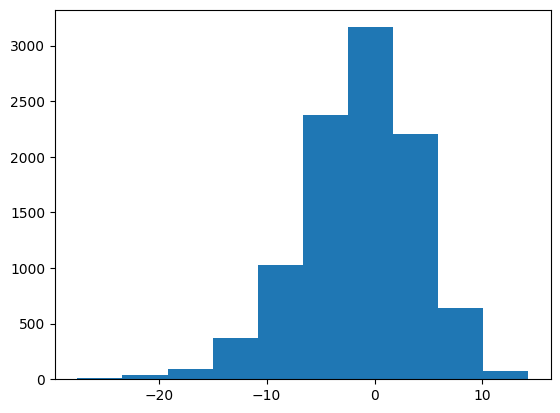

In [358]:
plt.hist(y_log)

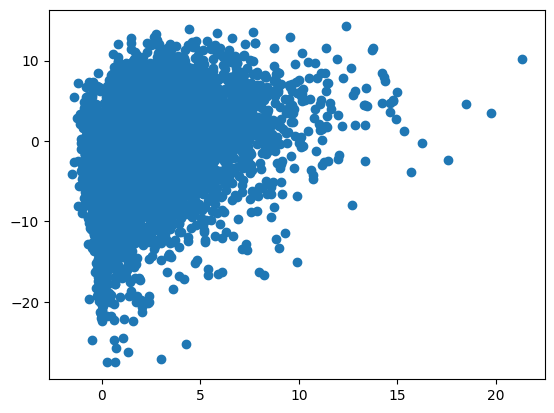

In [359]:
plt.scatter(x=T, y=y_log)

In [360]:
df = pd.DataFrame(dict(
    X=X,
    Y=y_log,
    T=T,
    W=W
))

model = smf.ols("Y ~ X + T + W", df)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     2362.
Date:                Mon, 07 Aug 2023   Prob (F-statistic):               0.00
Time:                        10:14:05   Log-Likelihood:                -28381.
No. Observations:               10000   AIC:                         5.677e+04
Df Residuals:                    9996   BIC:                         5.680e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0171      0.072    -84.100      0.000      -6.157      -5.877
X             -1.2018      0.171     -7.041      0.000      -1.536      -0.867
T              1.4530      0.083     17.515      0.000       1.290       1.616
W              2.9402      0.041     71.601      0.000       2.860       3.021
==============================================================================
Omnibus:                      953.954   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1593.328
Skew:                          -0.688   Prob(JB):                         0.00
Kurtosis:                       4.390   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [364]:
fitted = model.fit()

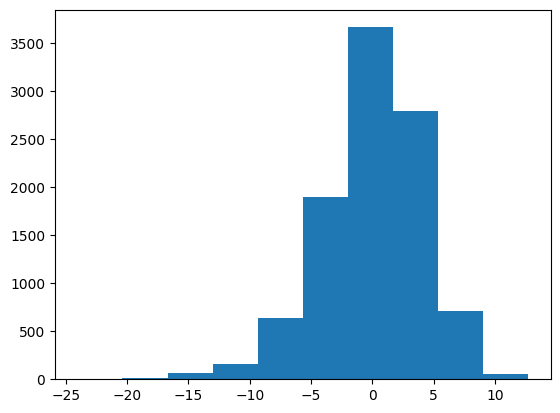

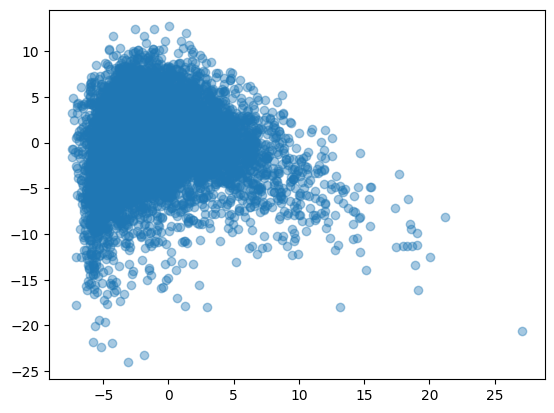

In [374]:
plt.hist(fitted.resid)
plt.show()

plt.scatter(
    x=fitted.fittedvalues,
    y=fitted.resid,
    alpha=.4)

In [375]:
linear, lasso, cf = get_estimates(df)

2023-08-07 10:21:08,457 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_model.py[line:463] - INFO: Model to find the causal effect of treatment ['T'] on outcome ['Y']
2023-08-07 10:21:08,459 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:727] - INFO: Causal effect can be identified.
2023-08-07 10:21:08,460 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:244] - INFO: Instrumental variables for treatment and outcome:['X']
2023-08-07 10:21:08,461 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:259] - INFO: Frontdoor variables for treatment and outcome:[]
2023-08-07 10:21:08,464 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/do

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[T]      
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,,U) = P(Y|T,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                   -1⎤
 ⎢ d      ⎛ d       ⎞  ⎥
E⎢────(Y)⋅⎜────([T])⎟  ⎥
 ⎣d[X]    ⎝d[X]     ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→Y then ¬(U →→{X})
Estimand assumption 2, Exclusion: If we remove {X}→{T}, then ¬({X}→Y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
2023-08-07 10:21:09,194 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_estimators/econml.py[line:106] - INFO: INFO: Using EconML Estimator
2023-08-07 10:21:09,199 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_estimators/econml.py[line:178] - INFO: b: Y~T | W
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
2023-08-07 10:21:09,871 - /Users/danieloliveiradebrito/Projetos/causal-inference/venv/lib/python3.9/site-packages/dowhy/causal_estimators/econml.py[line:106] - INFO: INFO: Using EconML Estimator
2023-08-07 10:21:09,979 - /Users/d

Linear DML *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[T]      
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,,U) = P(Y|T,)

## Realized estimand
b: Y~T | W
Target units: ate

## Estimate
Mean value: 0.8976267050338198
Effect estimates: [[0.883]
 [0.898]
 [0.892]
 ...
 [0.9  ]
 [0.887]
 [0.9  ]]
 





DML Lasso *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[T]      
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,,U) = P(Y|T,)

## Realized estimand
b: Y~T | W
Target units: ate

## Estimate
Mean value: 0.8960230402829399
Effect estimates: [[0.878]
 [0.897]
 [0.889]
 ...
 [0.899]
 [0.883]
 [0.898]]
 





Causal Forest *** Causal Estimate ***

## Identified estimand
Estimand ty

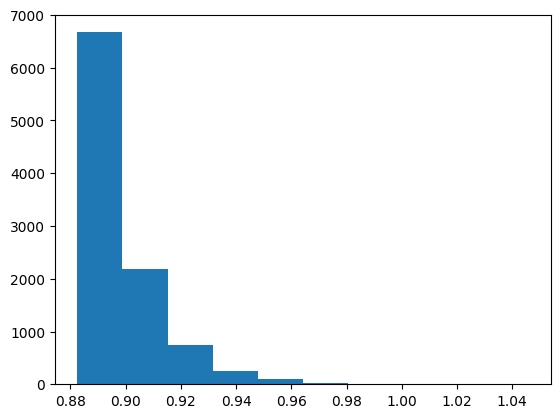

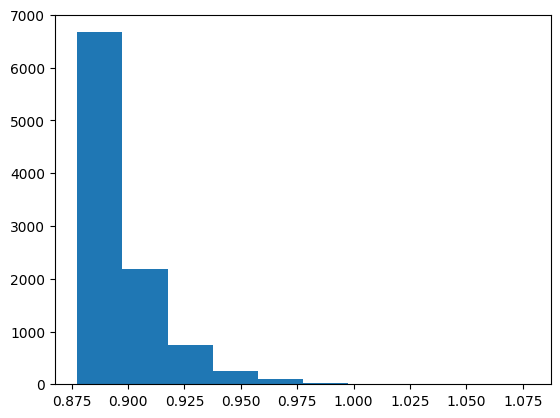

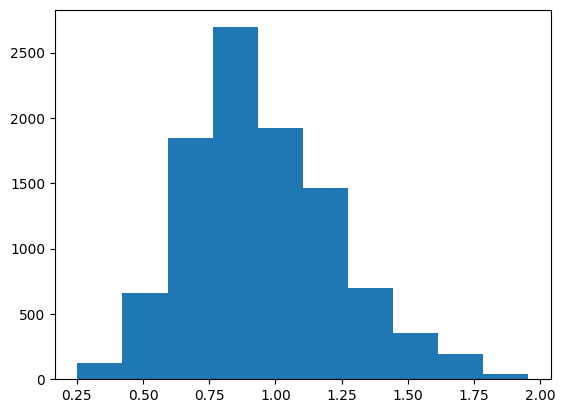

In [381]:
for est in [linear, lasso, cf]:
    plt.hist(est.cate_estimates)
    plt.show()

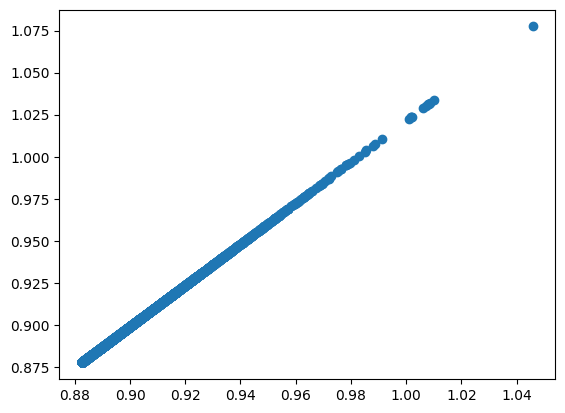

In [383]:
plt.scatter(x=linear.cate_estimates, y=lasso.cate_estimates)

dml_lasso


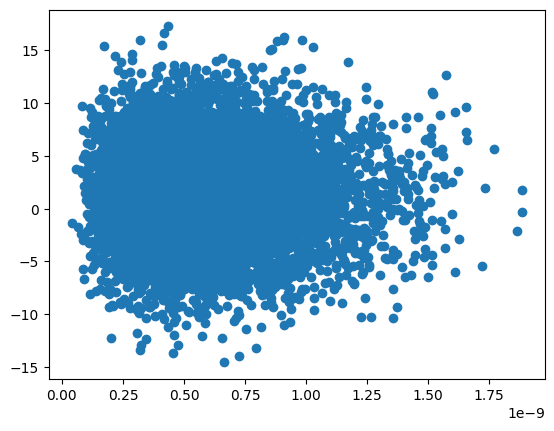

dml_linear


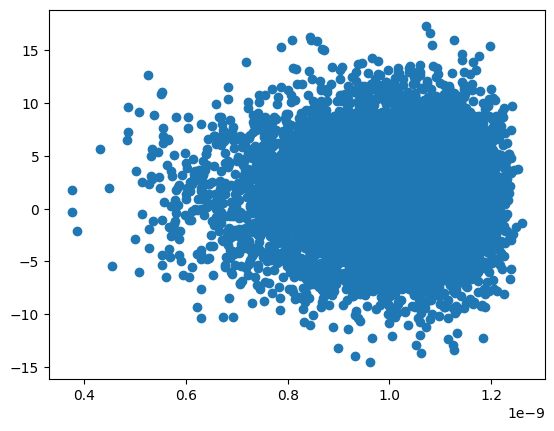

causal_forest


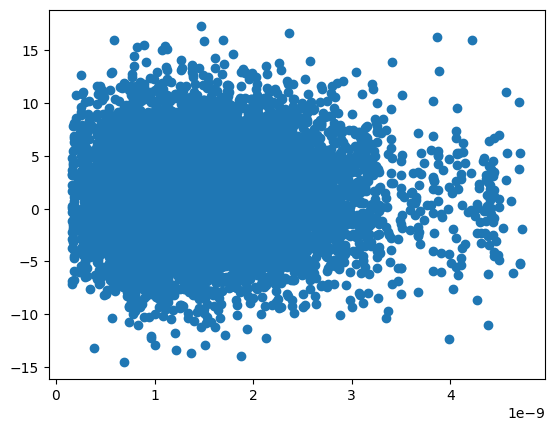

In [209]:
for est_name, est in dict(
    dml_lasso = estimate_dml_lasso,
    dml_linear = estimate_dml_linear,
    causal_forest = estimate_causal_forests
).items():
    print(est_name)

    plt.scatter(
        x=est.cate_estimates.T[0],
        y=true_effect
    )

    #plt.yscale("log")
    #plt.xscale("log")
    plt.show()

In [385]:
cf.

AttributeError: 'CausalEstimate' object has no attribute 'score'

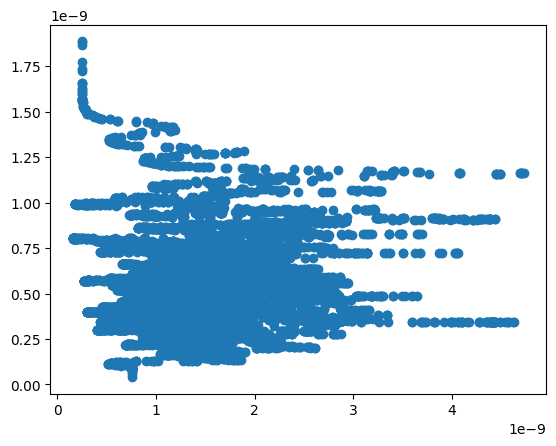

In [206]:
plt.scatter(x=estimate_causal_forests.cate_estimates,
            y=estimate_dml_lasso.cate_estimates)

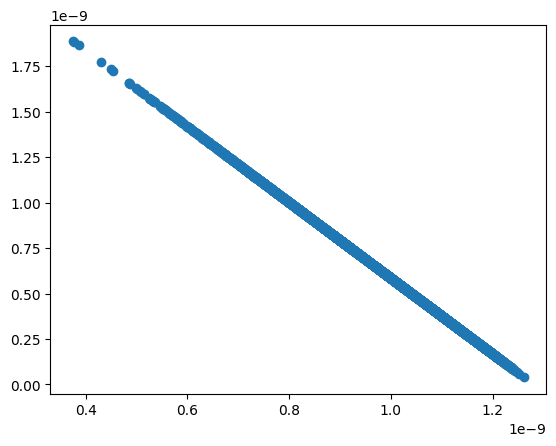

In [208]:
plt.scatter(x=estimate_dml_linear.cate_estimates,
            y=estimate_dml_lasso.cate_estimates)